You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os
if not os.path.isdir('k'):
 !git clone -b development15 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1598, done.
remote: Counting objects: 100% (1047/1047), done.
remote: Compressing objects: 100% (687/687), done.
remote: Total 1598 (delta 758), reused 616 (delta 355), pack-reused 551
Receiving objects: 100% (1598/1598), 15.08 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (1114/1114), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=60100 sha256=526b6b82c9c94927d6a21e428b86075b9ede30262eaf9617b26b2db853a507b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_z1vemoy/wheels/c1/8a/57/56dbba25eff58e52e53

In [2]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
import shutil

Tensorflow version: 2.8.0
Keras version: 2.8.0
CPU cores: 8
RAM: 54.767017984 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Thu Mar 10 03:51:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Download Files and Create Validation and Test Datasets

In [6]:
verbose=True
root_folder = 'malaria'
train_dir = root_folder + '/cell_images'
val_dir = root_folder + '/val'
test_dir = root_folder + '/test'

url_zip_file = 'https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip'
local_zip_file = 'malaria.zip'
expected_folder_name = root_folder

if not os.path.isdir(root_folder):
  cai.datasets.download_zip_and_extract(url_zip_file, local_zip_file, expected_folder_name, verbose)
  cai.datasets.extract_subset_every(train_dir, val_dir, move_every=10, shift=0, verbose=verbose)
  cai.datasets.extract_subset_every(train_dir, test_dir, move_every=9, shift=0, verbose=verbose)

Downloading:  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip  to  malaria.zip
Decompressing into:  malaria
Creating folder malaria/val
Creating folder malaria/val/Parasitized
Creating folder malaria/val/Uninfected
1378 files have been moved from malaria/cell_images/Parasitized to malaria/val/Parasitized.
1378 files have been moved from malaria/cell_images/Uninfected to malaria/val/Uninfected.
Creating folder malaria/test
Creating folder malaria/test/Parasitized
Creating folder malaria/test/Uninfected
1378 files have been moved from malaria/cell_images/Parasitized to malaria/test/Parasitized.
1378 files have been moved from malaria/cell_images/Uninfected to malaria/test/Uninfected.


In [7]:
!ls -l malaria/cell_images/Uninfected/ | wc -l

11025


In [8]:
num_classes = 2
batch_size = 64
epochs = 75
target_size_x = 224
target_size_y = 224
seed = 12
lab=False
bipolar=False
smart_resize=True

In [9]:
# load train dataset
x_train, aux_x_val, aux_x_test, y_train, aux_y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=train_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='train',
  training_size=1.0, validation_size=0.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=True, has_validation=False, has_testing=False, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading train images
train shape is: (22046, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 0.94509804
Channel  2  min: 0.0  max: 0.9647059
Loaded.


In [10]:
# load validation dataset
aux_x_train, x_val, aux_x_test, aux_y_train, y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=val_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='val',
  training_size=0.0, validation_size=1.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=True, has_testing=False, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading validation images
validation shape is: (2756, 224, 224, 3)
Loaded.


In [11]:
# Duplicate Validation by Flipping Horizontally
x_val = np.concatenate( (x_val, np.flip(x_val, 2)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

# Duplicate Validation Again by Flipping Vertically
x_val = np.concatenate( (x_val, np.flip(x_val, 1)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

print("x_val_shape:", x_val.shape)
print("y_val_shape:", y_val.shape)

x_val_shape: (11024, 224, 224, 3)
y_val_shape: (11024, 2)


In [12]:
# load test dataset
aux_x_train, aux_x_val, x_test, aux_y_train, aux_y_val, y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=test_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='test',
  training_size=0.0, validation_size=0.0, test_size=1.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=False, has_testing=True, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading test images
test shape is: (2756, 224, 224, 3)
Loaded.


In [13]:
train_datagen = cai.util.create_image_generator(vertical_flip=True,
  rotation_range=179, width_shift_range=0.3, height_shift_range=0.3,
  channel_shift_range=0.0)
valid_datagen = cai.util.create_image_generator_no_augmentation()
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    result = base_learning
    if local_epoch < 7:
       result = base_learning * (1 + 0.5*local_epoch)
    else:
       result = (base_learning * 4) * ( 0.85**(local_epoch-7) )

    if result < 2.5245e-04:
      result = 2.5245e-04
    return result

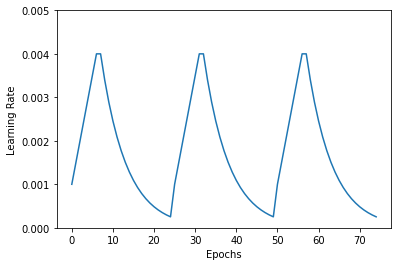

In [14]:
learning_rate_test = []
for epoch in range(epochs):
  learning_rate_test.append( cyclical_adv_lrscheduler25(epoch) )
plt.figure()
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.ylim([0.0000,0.005])
plt.plot(learning_rate_test)

In [15]:
def work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_loss'
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6v3_2ch()]:
      basefilename = '/content/drive/MyDrive/output/JP30M04-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          # skip_stride_cnt=0,
          kType=kType)
        
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model):
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed
            )
            validation_flow = valid_datagen.flow(
                x_val, y_val,
                batch_size=batch_size,
                shuffle=False,
                seed=seed
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=True, center_crop=0.15)
      print('Finished: '+basefilename)

# Show Models

In [16]:
work_on_keffnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30M04-46
Model: "kEffNet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 224, 224, 3)]                   0                    []                                                          
                                                                                                                                                                                    
 k_stem_conv_pad (ZeroPadding2D)                           (None, 225, 225, 3)                     0                    ['input_1[0][0]']                                           
                         

# Fitting

Running: /content/drive/MyDrive/output/JP30M04-46
Epoch 1/75
345/345 [==============================] - ETA: 0s - loss: 1.1524 - accuracy: 0.5414
Epoch 1: val_loss improved from inf to 0.70132, saving model to /content/drive/MyDrive/output/JP30M04-46-best_result.hdf5
345/345 [==============================] - 214s 478ms/step - loss: 1.1524 - accuracy: 0.5414 - val_loss: 0.7013 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/75
345/345 [==============================] - ETA: 0s - loss: 0.7904 - accuracy: 0.6101
Epoch 2: val_loss improved from 0.70132 to 0.56108, saving model to /content/drive/MyDrive/output/JP30M04-46-best_result.hdf5
345/345 [==============================] - 151s 434ms/step - loss: 0.7904 - accuracy: 0.6101 - val_loss: 0.5611 - val_accuracy: 0.7097 - lr: 0.0015
Epoch 3/75
345/345 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8172
Epoch 3: val_loss improved from 0.56108 to 0.24638, saving model to /content/drive/MyDrive/output/JP30M04-46-best_resu

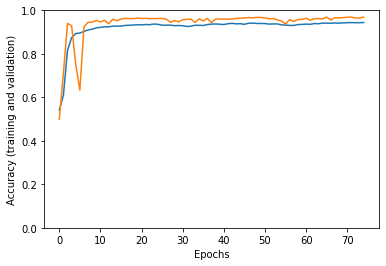

In [17]:
work_on_keffnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [18]:
work_on_keffnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30M04-46
Best Model Results: /content/drive/MyDrive/output/JP30M04-46-best_result.hdf5
44/44 [==============================] - 11s 66ms/step - loss: 0.0896 - accuracy: 0.9670
loss 0.08962380141019821
acc 0.9669811129570007
Finished: /content/drive/MyDrive/output/JP30M04-46


In [19]:
work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=True)

Running: /content/drive/MyDrive/output/JP30M04-46
Test Original
              precision    recall  f1-score   support

           0     0.9770    0.9565    0.9666      1378
           1     0.9574    0.9775    0.9673      1378

    accuracy                         0.9670      2756
   macro avg     0.9672    0.9670    0.9670      2756
weighted avg     0.9672    0.9670    0.9670      2756

Test Flip X
              precision    recall  f1-score   support

           0     0.9799    0.9543    0.9669      1378
           1     0.9554    0.9804    0.9678      1378

    accuracy                         0.9673      2756
   macro avg     0.9677    0.9673    0.9673      2756
weighted avg     0.9677    0.9673    0.9673      2756

Test Original + Flip X
              precision    recall  f1-score   support

           0     0.9785    0.9557    0.9670      1378
           1     0.9567    0.9790    0.9677      1378

    accuracy                         0.9673      2756
   macro avg     0.9676    0.